# 4.5 학습 알고리즘 구현하기  
(집에 있는 파일 merge 할 것)


## 4.5.1 2층 신경망 클래스 구현하기  

In [17]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

TwoLayerNet은 params와 grads라는 딕셔너리 인스턴스 변수를 갖는다.  
params 변수는 가중치 매개변수가 저장된다. (W: 가중치, b: 편향)  

In [18]:
net = TwoLayerNet(input_size =784, hidden_size = 100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


params 변수에는 위와같이 신경망에 필요한 가중치가 저장되어 있다.  
이 변수에 저장된 가중치 매개변수는 예측 처리 **(순방향 처리)**에 사용된다.  
예측 처리는 다음과 같이 실행 가능하다.

In [19]:
x = np.random.rand(100,784) # 더미 데이터 100개
y = net.predict(x)

grads 변수에는 params 변수에 대응하는 각 매개변수의 기울기가 저장된다.  

In [20]:
x = np.random.rand(100,784) # 더미 입력 데이터 100개
t = np.random.rand(100,10) # 더미 정답 레이블 100개

grads = net.numerical_gradient(x, t) # 기울기 계산

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


__init__(self, input_size, hidden)size, output_size): 클래스의 초기화, 즉 생성시의 생성자  
인수는 순서대로 입력층의 뉴련수, 은닉층의 뉴런수, 출력층의 뉴런수  
__init__에서는 매개변수도 초기화하는데, 초기 값을 어떤 값으로 설정하는지에 따라 신경망 학습의 성공률을 높일 수 있음  
일단 위에서는 가중치는 정규분포를 따르는 난수로, 편향은 0으로 초기화한다.  
loss 함수는 predict()의 결과와 정답 레이블을 바탕으로 교차 엔트로피 오차를 구하도록 구현했다.  
gradient는 다음 장에서 구현할 메소드 (기울기를 빠르게 얻을 수 있는 오차역전파법)  

## 4.5.2 미니배치 학습 구현하기  

In [24]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

미니배치의 크기는 100, 이 데이터를 확률적 경사 하강법을 수행해 매개변수를 갱신,  
갱신횟수(반복 횟수)는 10000번, 갱신할 때 마다 훈련 데이터에 대한 손실 함수를 계산하고, 그 값을 배열에 추가 한다.  
손실함수의 추이는 다음과 같다.  

<img src = "./image/fig_4_11.png" width="40%">  

## 4.5.3 시험 데이터로 평가하기  

신경망 학습에서는 훈련 데이터 외의 데이터를 올바르게 인식하는지를 확인해야 한다.  
즉 오버피팅을 일으키지 않는지를 확인해야 한다.  
따라서 구현 할 때 학습 도중 정기적으로 훈련 데이터와 시험 데이터에 대한 정확도를 기록해야 한다.  
여기서 **에폭**이란 학습에서 훈련 데이터를 모두 소진했을 때의 횟수에 해당한다.  

train acc, test acc | 0.09608333333333334, 0.0954
train acc, test acc | 0.8000166666666667, 0.8046
train acc, test acc | 0.8791166666666667, 0.8817
train acc, test acc | 0.898, 0.9019
train acc, test acc | 0.9074833333333333, 0.9094
train acc, test acc | 0.9142666666666667, 0.9154
train acc, test acc | 0.91835, 0.9199
train acc, test acc | 0.9227166666666666, 0.9247
train acc, test acc | 0.9271166666666667, 0.927
train acc, test acc | 0.9309833333333334, 0.9318
train acc, test acc | 0.93425, 0.9332
train acc, test acc | 0.93635, 0.9363
train acc, test acc | 0.9388166666666666, 0.938
train acc, test acc | 0.94175, 0.9392
train acc, test acc | 0.9434166666666667, 0.942
train acc, test acc | 0.9456333333333333, 0.9429
train acc, test acc | 0.9468, 0.9448


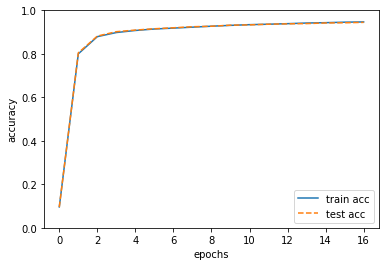

In [25]:
# 제대로 된 평가를 위해서 앞의 구현을 수정해 보기

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

에폭이 진행될수록 훈련 데이터와 시험데이터를 사용하고 평가한 정확도가 좋아지고 있다.  
또한 두 정확도의 차이가 거의 없으므로 오버피팅도 일어나지 않음을 알 수 알수 있다.  
오버피팅이 일어난다면 어느순간 정확도가 떨어진다.  
